In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# cnn model vary kernel size
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot

from tensorflow.keras.utils import to_categorical
import tensorflow.keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten, Reshape, LSTM, Conv1D, MaxPooling1D, Bidirectional, ConvLSTM1D
from tensorflow.keras.layers import Input, TimeDistributed, Conv1D, MaxPooling1D, BatchNormalization, GlobalAveragePooling1D, Activation
from tensorflow.python.keras.utils import np_utils
from sklearn.metrics import precision_score, recall_score, f1_score

from typing import Any, Dict, List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns


def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values



# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y


# load the dataset, returns train and test X and y elements
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + '/Users/ohheungchan/workspace/AI_Study/Paperwork/human+activity+recognition+using+smartphones/UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + '/Users/ohheungchan/workspace/AI_Study/Paperwork/human+activity+recognition+using+smartphones/UCI HAR Dataset/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1

    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

In [3]:
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


In [4]:
print("X train shape: ", trainX.shape)
print("Y train shape: ", trainy.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (7352, 128, 9)
Y train shape:  (7352, 1)
Y train One hot shape:  (7352, 6)
X test shape:  (2947, 128, 9)
Y test shape:  (2947, 1)
Y test One hot shape:  (2947, 6)


In [5]:
print("0: Walking:" ,np.where(trainy == 0)[0].size)
print("1: WU:" ,np.where(trainy == 1)[0].size)
print("2: WD:" ,np.where(trainy == 2)[0].size)
print("3: Sitting:" ,np.where(trainy == 3)[0].size)
print("4: Standing:" ,np.where(trainy == 4)[0].size)
print("5: Laying:" ,np.where(trainy == 5)[0].size)

0: Walking: 1226
1: WU: 1073
2: WD: 986
3: Sitting: 1286
4: Standing: 1374
5: Laying: 1407


In [6]:
unique, counts = np.unique(trainy, return_counts=True)
print ("Train data label statistics::")
print (np.asarray((unique, counts)).T)

unique, counts = np.unique(testy, return_counts=True)
print ("Test data label statistics::")
print (np.asarray((unique, counts)).T)

Train data label statistics::
[[   0 1226]
 [   1 1073]
 [   2  986]
 [   3 1286]
 [   4 1374]
 [   5 1407]]
Test data label statistics::
[[  0 496]
 [  1 471]
 [  2 420]
 [  3 491]
 [  4 532]
 [  5 537]]


In [7]:
X_train_all = trainX   # at this stage, the data includes both dynamic and static HAR data
y_train_all = trainy

X_test_all = testX
y_test_all = testy
     

In [8]:
trainy_one_hot = to_categorical(trainy)
testy_one_hot = to_categorical(testy)

In [9]:
print("X train shape: ", trainX.shape)
print("Y train shape: ", trainy.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (7352, 128, 9)
Y train shape:  (7352, 1)
Y train One hot shape:  (7352, 6)
X test shape:  (2947, 128, 9)
Y test shape:  (2947, 1)
Y test One hot shape:  (2947, 6)


In [10]:
n_steps = 4
n_features = trainX.shape[2]
n_length = 32

trainX = trainX.reshape((trainX.shape[0], n_steps, n_length, n_features))
testX = testX.reshape((testX.shape[0], n_steps, n_length, n_features))
#X_val = X_val.reshape((X_val.shape[0], n_steps, n_length, n_features))
print(trainX.shape,testX.shape)

(7352, 4, 32, 9) (2947, 4, 32, 9)


In [11]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.3,random_state=100)
     

In [12]:
n_timesteps, n_features, n_outputs = n_steps * n_length, trainX.shape[3], testy_one_hot.shape[1]
     

# CNN-LSTM

In [14]:
# Model 1
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))

model.add(TimeDistributed(Dropout(0.5)))

model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))

model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

2024-03-15 21:48:14.471818: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-15 21:48:14.472849: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M2 Pro
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, None, 30, 64)     1792      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, None, 30, 64)     0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, None, 15, 64)     0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, None, 960)        0         
 tributed)                                                       
                                                                 
 lstm (LSTM)          

In [15]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)

     

Epoch 1/10


2024-03-15 21:50:44.173829: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-03-15 21:50:45.190430: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 21:50:45.559802: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 21:50:46.951305: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


58/58 [==============================] - ETA: 0s - loss: 0.7650 - accuracy: 0.6847

2024-03-15 21:50:49.766123: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 21:50:49.835529: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


58/58 [==============================] - 6s 39ms/step - loss: 0.7650 - accuracy: 0.6847 - val_loss: 0.4303 - val_accuracy: 0.8359
Epoch 2/10
58/58 [==============================] - 1s 18ms/step - loss: 0.3364 - accuracy: 0.8670 - val_loss: 0.2573 - val_accuracy: 0.9007
Epoch 3/10
58/58 [==============================] - 1s 19ms/step - loss: 0.2102 - accuracy: 0.9202 - val_loss: 0.1722 - val_accuracy: 0.9465
Epoch 4/10
58/58 [==============================] - 1s 18ms/step - loss: 0.1525 - accuracy: 0.9391 - val_loss: 0.1315 - val_accuracy: 0.9551
Epoch 5/10
58/58 [==============================] - 1s 18ms/step - loss: 0.1292 - accuracy: 0.9479 - val_loss: 0.1266 - val_accuracy: 0.9447
Epoch 6/10
58/58 [==============================] - 1s 18ms/step - loss: 0.1209 - accuracy: 0.9531 - val_loss: 0.1153 - val_accuracy: 0.9565
Epoch 7/10
58/58 [==============================] - 1s 18ms/step - loss: 0.1237 - accuracy: 0.9491 - val_loss: 0.1148 - val_accuracy: 0.9583
Epoch 8/10
58/58 [======

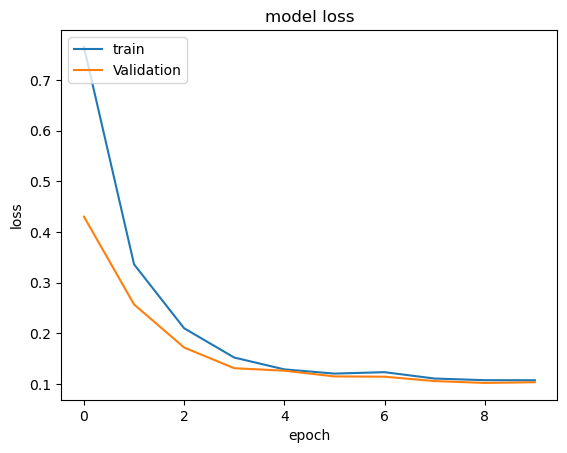

In [16]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

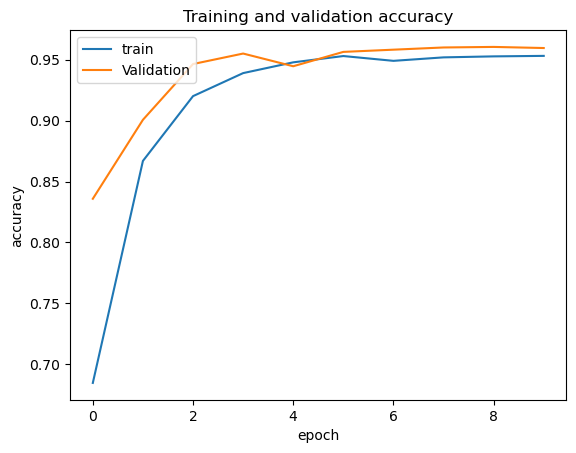

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

2024-03-15 21:51:44.500086: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 21:51:44.560333: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


93/93 [==============================] - 2s 19ms/step
[[448   3  45   0   0   0]
 [  0 446  25   0   0   0]
 [  4   1 415   0   0   0]
 [  0  25   0 376  90   0]
 [  2   1   0  88 441   0]
 [  0  27   0   0   0 510]]
0.8944689514760774
0.8943141503537229
              precision    recall  f1-score   support

           0       0.99      0.90      0.94       496
           1       0.89      0.95      0.92       471
           2       0.86      0.99      0.92       420
           3       0.81      0.77      0.79       491
           4       0.83      0.83      0.83       532
           5       1.00      0.95      0.97       537

    accuracy                           0.89      2947
   macro avg       0.89      0.90      0.89      2947
weighted avg       0.90      0.89      0.89      2947



<Axes: >

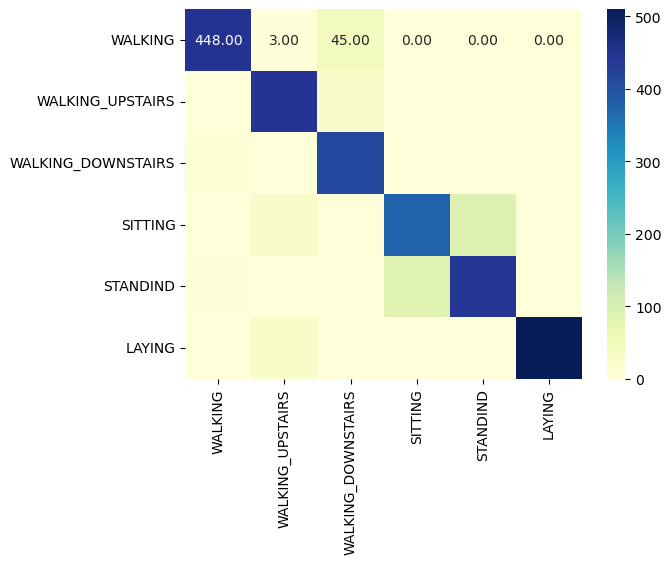

In [18]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')
     

# CNN1-LSTM2

In [19]:

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))

model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))

model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_4 (TimeDis  (None, None, 30, 64)     1792      
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, None, 30, 64)     0         
 tributed)                                                       
                                                                 
 time_distributed_6 (TimeDis  (None, None, 15, 64)     0         
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, None, 960)        0         
 tributed)                                                       
                                                                 
 lstm_1 (LSTM)               (None, None, 100)        

In [20]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10


2024-03-15 21:53:03.699303: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 21:53:03.960820: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 21:53:04.059953: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 21:53:04.355482: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/58 [..............................] - ETA: 2:24 - loss: 1.7955 - accuracy: 0.1406

2024-03-15 21:53:04.565788: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


58/58 [==============================] - ETA: 0s - loss: 0.8463 - accuracy: 0.6529

2024-03-15 21:53:06.602750: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 21:53:06.700851: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 21:53:06.771678: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


58/58 [==============================] - 5s 43ms/step - loss: 0.8463 - accuracy: 0.6529 - val_loss: 0.4237 - val_accuracy: 0.8386
Epoch 2/10
58/58 [==============================] - 1s 24ms/step - loss: 0.3442 - accuracy: 0.8701 - val_loss: 0.3239 - val_accuracy: 0.8708
Epoch 3/10
58/58 [==============================] - 1s 24ms/step - loss: 0.2085 - accuracy: 0.9230 - val_loss: 0.1840 - val_accuracy: 0.9248
Epoch 4/10
58/58 [==============================] - 1s 24ms/step - loss: 0.1556 - accuracy: 0.9397 - val_loss: 0.1304 - val_accuracy: 0.9470
Epoch 5/10
58/58 [==============================] - 1s 24ms/step - loss: 0.1308 - accuracy: 0.9490 - val_loss: 0.1343 - val_accuracy: 0.9424
Epoch 6/10
58/58 [==============================] - 1s 24ms/step - loss: 0.1212 - accuracy: 0.9502 - val_loss: 0.1081 - val_accuracy: 0.9578
Epoch 7/10
58/58 [==============================] - 1s 25ms/step - loss: 0.1180 - accuracy: 0.9520 - val_loss: 0.1046 - val_accuracy: 0.9578
Epoch 8/10
58/58 [======

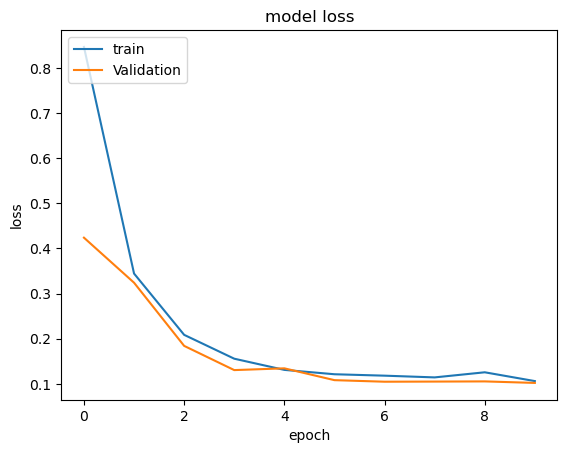

In [21]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
     

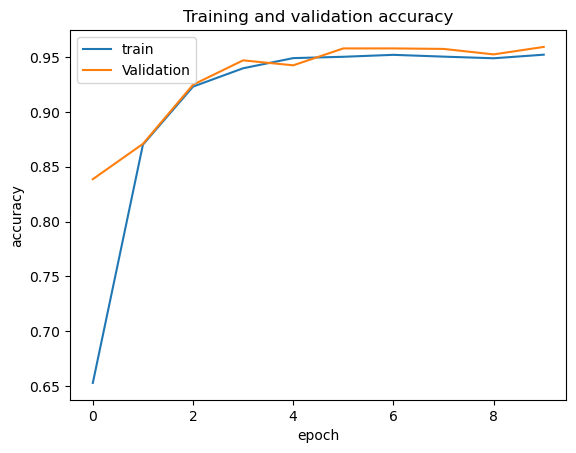

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

2024-03-15 21:54:49.039127: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 21:54:49.125350: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 21:54:49.210056: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


93/93 [==============================] - 1s 5ms/step
[[459   2  23   1  11   0]
 [  8 438  24   0   1   0]
 [ 19  11 390   0   0   0]
 [  0  24   0 383  84   0]
 [  0   1   0  83 448   0]
 [  0  27   0   0   0 510]]
0.8917543264336614
0.8918555381061117
              precision    recall  f1-score   support

           0       0.94      0.93      0.93       496
           1       0.87      0.93      0.90       471
           2       0.89      0.93      0.91       420
           3       0.82      0.78      0.80       491
           4       0.82      0.84      0.83       532
           5       1.00      0.95      0.97       537

    accuracy                           0.89      2947
   macro avg       0.89      0.89      0.89      2947
weighted avg       0.89      0.89      0.89      2947



<Axes: >

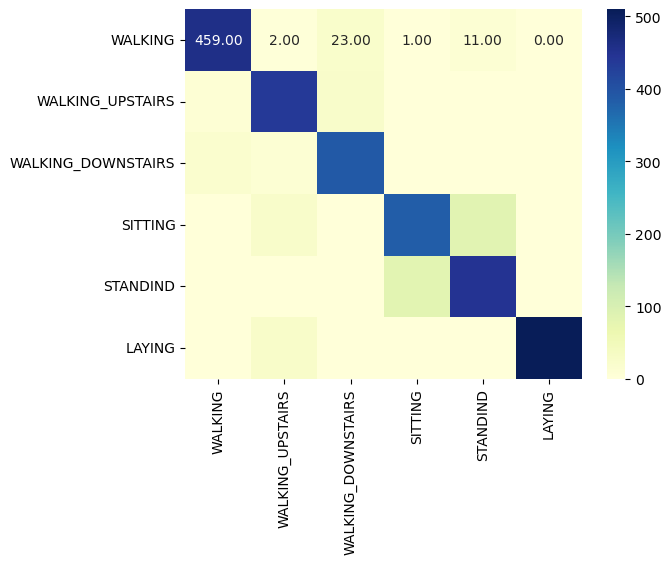

In [23]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')
     

# CNN2 - LSTM1

In [24]:
# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))

model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))


model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_8 (TimeDis  (None, None, 30, 64)     1792      
 tributed)                                                       
                                                                 
 time_distributed_9 (TimeDis  (None, None, 28, 64)     12352     
 tributed)                                                       
                                                                 
 time_distributed_10 (TimeDi  (None, None, 28, 64)     0         
 stributed)                                                      
                                                                 
 time_distributed_11 (TimeDi  (None, None, 14, 64)     0         
 stributed)                                                      
                                                                 
 time_distributed_12 (TimeDi  (None, None, 896)       

In [25]:

# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10


2024-03-15 21:55:05.685098: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 21:55:05.992088: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 21:55:06.179972: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


58/58 [==============================] - ETA: 0s - loss: 0.7061 - accuracy: 0.7246

2024-03-15 21:55:08.046735: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 21:55:08.129921: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


58/58 [==============================] - 4s 33ms/step - loss: 0.7061 - accuracy: 0.7246 - val_loss: 0.3551 - val_accuracy: 0.8554
Epoch 2/10
58/58 [==============================] - 1s 20ms/step - loss: 0.2534 - accuracy: 0.9067 - val_loss: 0.1774 - val_accuracy: 0.9429
Epoch 3/10
58/58 [==============================] - 1s 20ms/step - loss: 0.1660 - accuracy: 0.9369 - val_loss: 0.1375 - val_accuracy: 0.9506
Epoch 4/10
58/58 [==============================] - 1s 20ms/step - loss: 0.1624 - accuracy: 0.9329 - val_loss: 0.1440 - val_accuracy: 0.9465
Epoch 5/10
58/58 [==============================] - 1s 20ms/step - loss: 0.1242 - accuracy: 0.9480 - val_loss: 0.1315 - val_accuracy: 0.9515
Epoch 6/10
58/58 [==============================] - 1s 19ms/step - loss: 0.1208 - accuracy: 0.9495 - val_loss: 0.1098 - val_accuracy: 0.9574
Epoch 7/10
58/58 [==============================] - 1s 19ms/step - loss: 0.1144 - accuracy: 0.9504 - val_loss: 0.1134 - val_accuracy: 0.9587
Epoch 8/10
58/58 [======

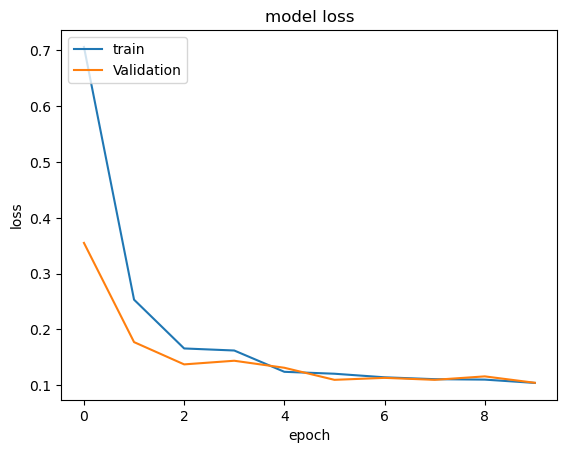

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

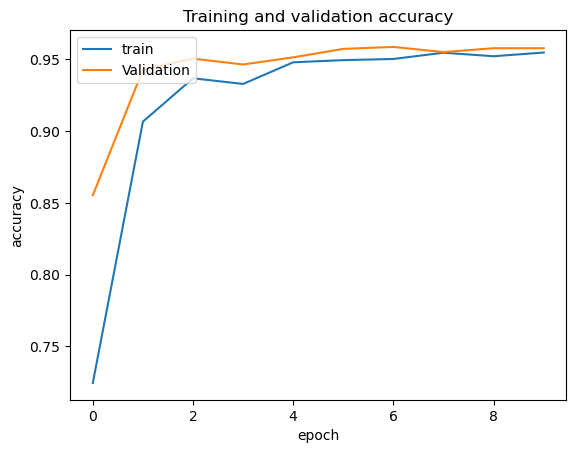

In [27]:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

 1/93 [..............................] - ETA: 29s

2024-03-15 21:56:27.900347: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 21:56:27.970639: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


93/93 [==============================] - 1s 10ms/step
[[413  38  45   0   0   0]
 [  0 451  20   0   0   0]
 [  3   9 408   0   0   0]
 [  0  25   0 385  81   0]
 [  2   4   0  92 434   0]
 [  0  27   0   0   0 510]]
0.8825924669155073
0.8826864321858631
              precision    recall  f1-score   support

           0       0.99      0.83      0.90       496
           1       0.81      0.96      0.88       471
           2       0.86      0.97      0.91       420
           3       0.81      0.78      0.80       491
           4       0.84      0.82      0.83       532
           5       1.00      0.95      0.97       537

    accuracy                           0.88      2947
   macro avg       0.89      0.89      0.88      2947
weighted avg       0.89      0.88      0.88      2947



<Axes: >

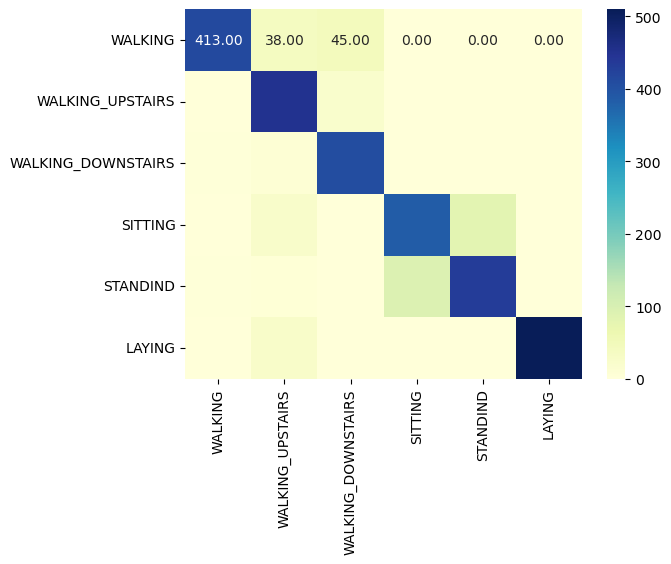

In [28]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')
     

# CNN2-LSTM2

In [29]:


# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))

model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))

model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_13 (TimeDi  (None, None, 30, 64)     1792      
 stributed)                                                      
                                                                 
 time_distributed_14 (TimeDi  (None, None, 28, 64)     12352     
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, None, 28, 64)     0         
 stributed)                                                      
                                                                 
 time_distributed_16 (TimeDi  (None, None, 14, 64)     0         
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, None, 896)       

In [30]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)

   

Epoch 1/10


2024-03-15 21:56:43.164392: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 21:56:43.444270: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 21:56:43.537872: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 21:56:43.731561: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 21:56:43.914505: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


58/58 [==============================] - ETA: 0s - loss: 0.8402 - accuracy: 0.6655

2024-03-15 21:56:46.052576: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 21:56:46.167870: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 21:56:46.243981: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


58/58 [==============================] - 5s 46ms/step - loss: 0.8402 - accuracy: 0.6655 - val_loss: 0.4359 - val_accuracy: 0.8282
Epoch 2/10
58/58 [==============================] - 2s 27ms/step - loss: 0.3458 - accuracy: 0.8696 - val_loss: 0.2324 - val_accuracy: 0.9098
Epoch 3/10
58/58 [==============================] - 2s 26ms/step - loss: 0.2028 - accuracy: 0.9260 - val_loss: 0.1747 - val_accuracy: 0.9374
Epoch 4/10
58/58 [==============================] - 2s 26ms/step - loss: 0.1579 - accuracy: 0.9404 - val_loss: 0.1543 - val_accuracy: 0.9347
Epoch 5/10
58/58 [==============================] - 2s 26ms/step - loss: 0.1484 - accuracy: 0.9400 - val_loss: 0.1224 - val_accuracy: 0.9515
Epoch 6/10
58/58 [==============================] - 2s 26ms/step - loss: 0.1227 - accuracy: 0.9487 - val_loss: 0.1122 - val_accuracy: 0.9542
Epoch 7/10
58/58 [==============================] - 2s 26ms/step - loss: 0.1213 - accuracy: 0.9509 - val_loss: 0.1317 - val_accuracy: 0.9442
Epoch 8/10
58/58 [======

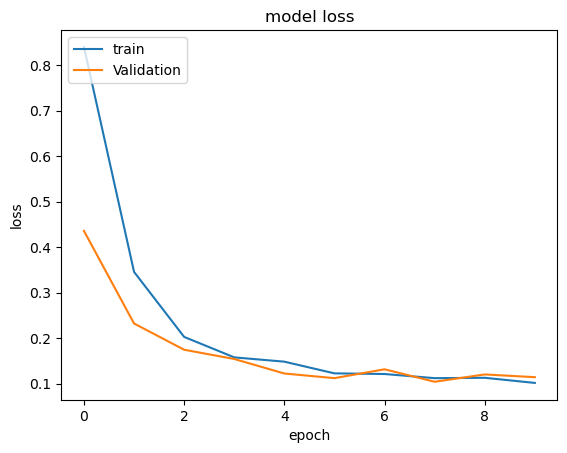

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

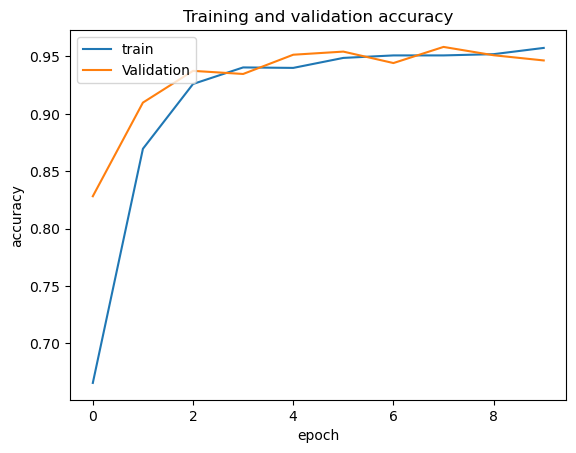

In [32]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

2024-03-15 21:57:40.730225: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 21:57:40.831633: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 21:57:40.913477: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


93/93 [==============================] - 1s 5ms/step
[[417  20  59   0   0   0]
 [  0 437  34   0   0   0]
 [  2   3 415   0   0   0]
 [  0  25   0 371  95   0]
 [  2   2   0  72 456   0]
 [  0  27   0   0   0 510]]
0.8842891075670173
0.8842529411946722
              precision    recall  f1-score   support

           0       0.99      0.84      0.91       496
           1       0.85      0.93      0.89       471
           2       0.82      0.99      0.89       420
           3       0.84      0.76      0.79       491
           4       0.83      0.86      0.84       532
           5       1.00      0.95      0.97       537

    accuracy                           0.88      2947
   macro avg       0.89      0.89      0.88      2947
weighted avg       0.89      0.88      0.88      2947



<Axes: >

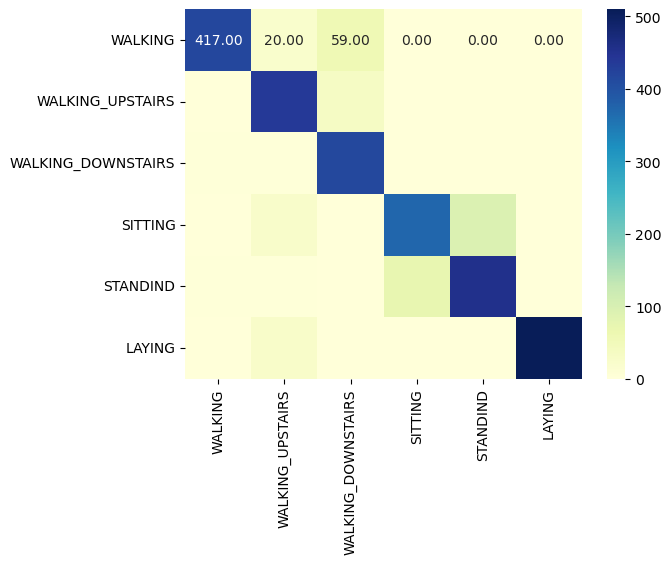

In [33]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')
     

In [42]:


# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))

model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))

model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))

model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.5))

model.add(LSTM(100))

model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_54 (TimeDi  (None, None, 30, 64)     1792      
 stributed)                                                      
                                                                 
 time_distributed_55 (TimeDi  (None, None, 28, 64)     12352     
 stributed)                                                      
                                                                 
 time_distributed_56 (TimeDi  (None, None, 26, 64)     12352     
 stributed)                                                      
                                                                 
 time_distributed_57 (TimeDi  (None, None, 26, 64)     0         
 stributed)                                                      
                                                                 
 time_distributed_58 (TimeDi  (None, None, 13, 64)   

In [43]:

# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10


2024-03-15 22:03:46.032460: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 22:03:46.468774: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 22:03:46.597697: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 22:03:46.720102: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 22:03:46.920306: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 22:03:47.126241: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 22:03:47.339736: I tensorflow/core/grappler/optimizers/cust

58/58 [==============================] - ETA: 0s - loss: 1.0001 - accuracy: 0.5431

2024-03-15 22:03:50.549691: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 22:03:50.720625: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 22:03:50.821031: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 22:03:50.917872: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


58/58 [==============================] - 8s 67ms/step - loss: 1.0001 - accuracy: 0.5431 - val_loss: 0.5951 - val_accuracy: 0.7076
Epoch 2/10
58/58 [==============================] - 2s 32ms/step - loss: 0.5236 - accuracy: 0.7530 - val_loss: 0.4005 - val_accuracy: 0.7947
Epoch 3/10
58/58 [==============================] - 2s 31ms/step - loss: 0.3169 - accuracy: 0.8731 - val_loss: 0.2065 - val_accuracy: 0.9175
Epoch 4/10
58/58 [==============================] - 2s 31ms/step - loss: 0.1963 - accuracy: 0.9240 - val_loss: 0.1528 - val_accuracy: 0.9379
Epoch 5/10
58/58 [==============================] - 2s 31ms/step - loss: 0.1531 - accuracy: 0.9378 - val_loss: 0.1597 - val_accuracy: 0.9347
Epoch 6/10
58/58 [==============================] - 2s 32ms/step - loss: 0.1439 - accuracy: 0.9416 - val_loss: 0.1239 - val_accuracy: 0.9483
Epoch 7/10
58/58 [==============================] - 2s 32ms/step - loss: 0.1280 - accuracy: 0.9480 - val_loss: 0.1149 - val_accuracy: 0.9519
Epoch 8/10
58/58 [======

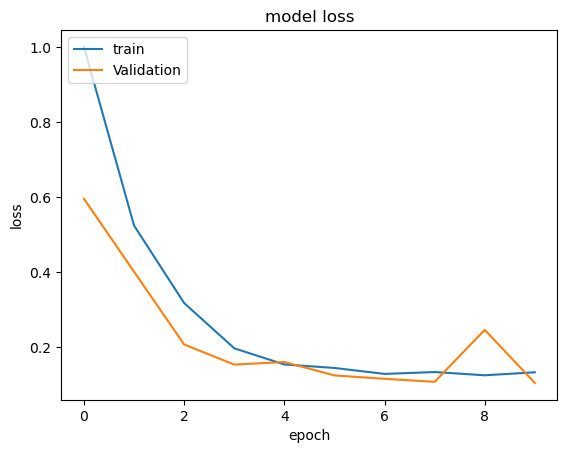

In [44]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

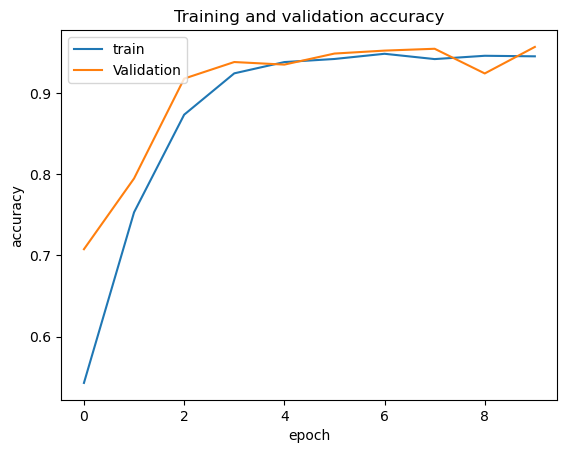

In [45]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')


2024-03-15 22:04:45.779599: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 22:04:45.922981: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/93 [..............................] - ETA: 1:14

2024-03-15 22:04:45.997530: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 22:04:46.080347: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


93/93 [==============================] - 1s 7ms/step
[[468  16  12   0   0   0]
 [ 24 423  24   0   0   0]
 [  2  12 406   0   0   0]
 [  1  20   6 421  43   0]
 [ 10   1   0 111 410   0]
 [  0  27   1   0   0 509]]
0.8948082796063793
0.894695811565998
              precision    recall  f1-score   support

           0       0.93      0.94      0.94       496
           1       0.85      0.90      0.87       471
           2       0.90      0.97      0.93       420
           3       0.79      0.86      0.82       491
           4       0.91      0.77      0.83       532
           5       1.00      0.95      0.97       537

    accuracy                           0.89      2947
   macro avg       0.90      0.90      0.90      2947
weighted avg       0.90      0.89      0.89      2947



<Axes: >

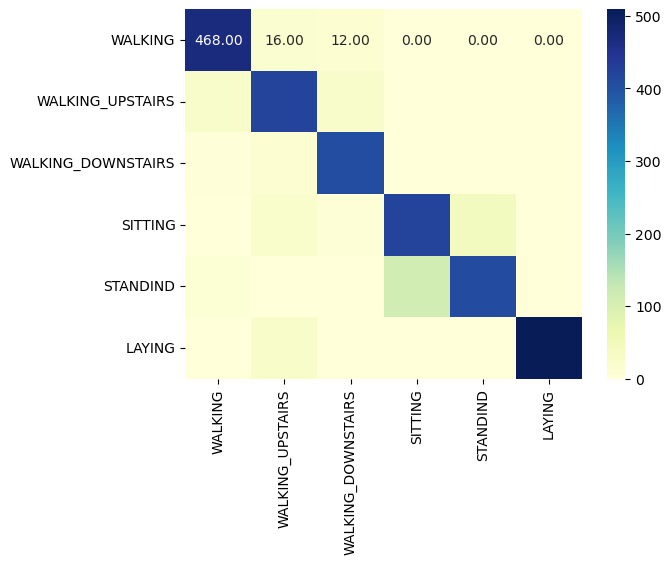

In [46]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')
     

# CNN-LSTM-CNN

In [51]:
from keras.models import Sequential
from keras.layers import Conv1D, LSTM, TimeDistributed, Dropout, MaxPooling1D, Flatten, Dense, Reshape

# define model
model = Sequential()

# 첫 번째 CNN 레이어
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))

# 두 번째 CNN 레이어
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))

# LSTM 레이어
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(100))

# 데이터를 3D에서 2D로 변환하는 Reshape 레이어 추가
model.add(Reshape((-1, 1)))

# 세 번째 CNN 레이어
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())

# 완전 연결 레이어
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))

# 모델 컴파일
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_74 (TimeDi  (None, None, 30, 64)     1792      
 stributed)                                                      
                                                                 
 time_distributed_75 (TimeDi  (None, None, 28, 64)     12352     
 stributed)                                                      
                                                                 
 time_distributed_76 (TimeDi  (None, None, 28, 64)     0         
 stributed)                                                      
                                                                 
 time_distributed_77 (TimeDi  (None, None, 14, 64)     0         
 stributed)                                                      
                                                                 
 time_distributed_78 (TimeDi  (None, None, 896)      

In [52]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)

     

Epoch 1/10


2024-03-15 22:09:31.877307: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 22:09:32.198056: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 22:09:32.324461: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 22:09:33.386360: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 22:09:33.588986: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


58/58 [==============================] - ETA: 0s - loss: 0.7965 - accuracy: 0.6590

2024-03-15 22:09:36.260366: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 22:09:36.377049: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 22:09:36.456836: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


58/58 [==============================] - 7s 59ms/step - loss: 0.7965 - accuracy: 0.6590 - val_loss: 0.3711 - val_accuracy: 0.8599
Epoch 2/10
58/58 [==============================] - 2s 27ms/step - loss: 0.2987 - accuracy: 0.8833 - val_loss: 0.1980 - val_accuracy: 0.9311
Epoch 3/10
58/58 [==============================] - 2s 27ms/step - loss: 0.1864 - accuracy: 0.9266 - val_loss: 0.1553 - val_accuracy: 0.9465
Epoch 4/10
58/58 [==============================] - 2s 27ms/step - loss: 0.1528 - accuracy: 0.9399 - val_loss: 0.1390 - val_accuracy: 0.9442
Epoch 5/10
58/58 [==============================] - 2s 27ms/step - loss: 0.1425 - accuracy: 0.9438 - val_loss: 0.1327 - val_accuracy: 0.9529
Epoch 6/10
58/58 [==============================] - 2s 27ms/step - loss: 0.1209 - accuracy: 0.9476 - val_loss: 0.1127 - val_accuracy: 0.9542
Epoch 7/10
58/58 [==============================] - 2s 28ms/step - loss: 0.1069 - accuracy: 0.9527 - val_loss: 0.1105 - val_accuracy: 0.9560
Epoch 8/10
58/58 [======

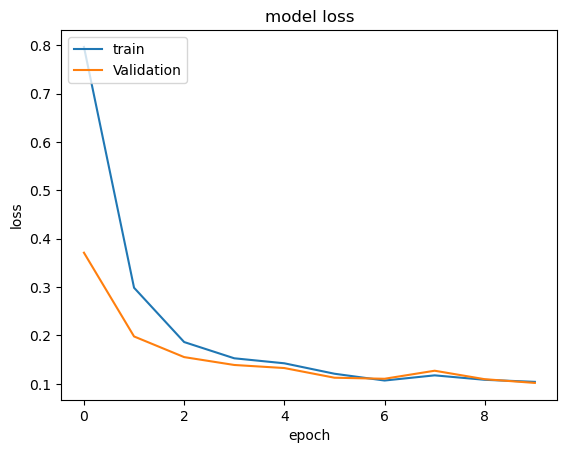

In [53]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

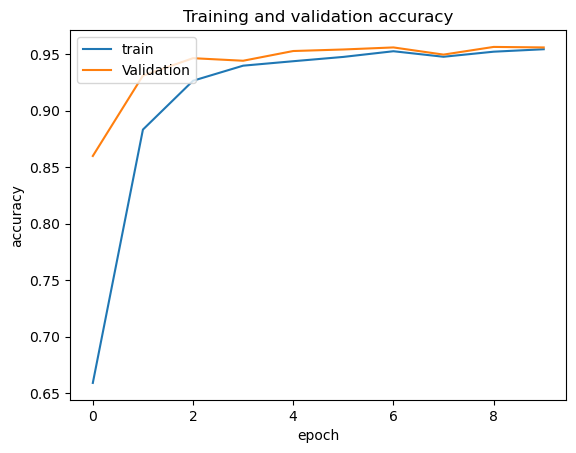

In [54]:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
     

2024-03-15 22:10:21.197904: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-15 22:10:21.318057: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 9/93 [=>............................] - ETA: 0s  

2024-03-15 22:10:21.411535: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


93/93 [==============================] - 2s 11ms/step
[[491   0   5   0   0   0]
 [ 10 436  25   0   0   0]
 [ 31   3 386   0   0   0]
 [  1  24   0 392  74   0]
 [  4   0   0 103 425   0]
 [  0  27   0   0   0 510]]
0.8958262639972854
0.8954542585227542
              precision    recall  f1-score   support

           0       0.91      0.99      0.95       496
           1       0.89      0.93      0.91       471
           2       0.93      0.92      0.92       420
           3       0.79      0.80      0.80       491
           4       0.85      0.80      0.82       532
           5       1.00      0.95      0.97       537

    accuracy                           0.90      2947
   macro avg       0.90      0.90      0.90      2947
weighted avg       0.90      0.90      0.90      2947



<Axes: >

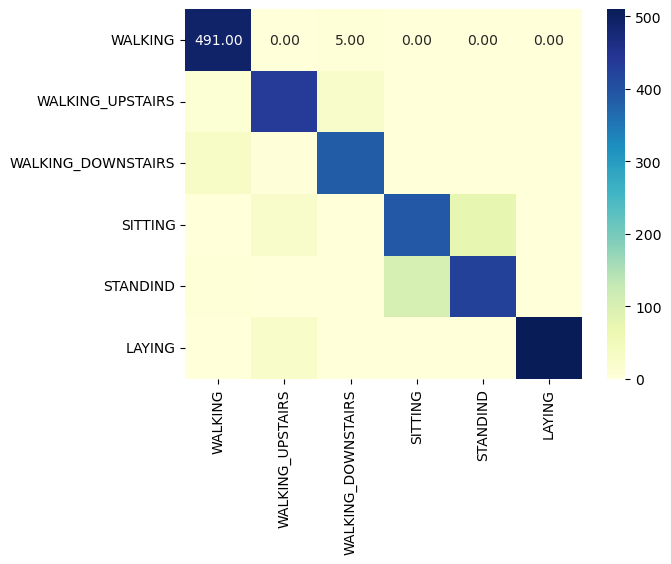

In [55]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')
     